In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
    
print(device)

cuda


In [3]:
# 전처리
root_dir = os.path.expanduser('./chest_xray')
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),
    transforms.ToTensor()]
)
input_dim = 128 * 128

trainval_ds = datasets.ImageFolder(os.path.join(root_dir, 'train'), transform = transform)
train_size = int(0.8 * len(trainval_ds))
val_size = len(trainval_ds) - train_size
train_ds, val_ds = random_split(trainval_ds, [train_size, val_size], generator = torch.Generator().manual_seed(42))
test_ds = datasets.ImageFolder(os.path.join(root_dir, 'test'), transform = transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
test_loader = DataLoader(test_ds, batch_size=32)

# DataLoader 확인
# dataiter = iter(train_loader)
# images, labels = next(dataiter)
# print(images.shape, labels)

In [4]:
# class로 정의된 각 모델 부분
class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        self.fc = nn.Linear(input_dim, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = x.view(x.size(0), -1) # Flatten the input
        x = self.fc(x)
        out = self.sigmoid(x)
        return out

class DeepNN(nn.Module):
    def __init__(self, input_dim):
        super(DeepNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        out = self.layers(x)
        return out

In [5]:
# 학습, 테스트 진행
def train(model, loader, optimizer, criterion):
    model.train()
    running_loss   = 0.0
    correct   = 0
    total   = 0
    for inputs, labels in loader:
        inputs, labels   = inputs.to(device), labels.float().to(device)
        optimizer.zero_grad()
        outputs   = model(inputs)
        loss   = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        predicted   = (outputs > 0.5).float().squeeze()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def evaluate(model, loader, criterion):
    model.eval()
    running_loss   = 0.0
    correct   = 0
    total   = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels   = inputs.to(device), labels.float().to(device)
            outputs   = model(inputs)
            loss   = criterion(outputs.squeeze(), labels)
            running_loss += loss.item()
            predicted   = (outputs > 0.5).float().squeeze()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [ ]:
# 학습 함수를 통해 학습 진행
logreg_model   = LogisticRegression(input_dim).to(device)
deepnn_model   = DeepNN(input_dim).to(device)

learning_rate = 0.001
criterion   = nn.BCELoss()
logreg_optimizer   = optim.Adam(logreg_model.parameters(), lr= learning_rate)
deepnn_optimizer   = optim.Adam(deepnn_model.parameters(), lr= learning_rate)

num_epochs   = 20
target_epochs = [1, 9, 19]
train_losses_logreg, val_losses_logreg, train_losses_deepnn, val_losses_deepnn = [], [], [], []
train_accs_logreg, val_accs_logreg, test_accs_logreg, train_accs_deepnn, val_accs_deepnn, test_accs_deepnn = [], [], [], [], [], []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    train_loss_logreg, train_acc_logreg   = train(logreg_model, train_loader, logreg_optimizer, criterion)
    print(f"Logistic Regression - Train Loss: {train_loss_logreg:.4f}, Train Acc: {train_acc_logreg:.4f}")
    
    val_loss_logreg, val_acc_logreg   = evaluate(logreg_model, val_loader, criterion)
    print(f"Logistic Regression - Val Loss: {val_loss_logreg:.4f}, Val Acc: {val_acc_logreg:.4f}")
    
    train_loss_deepnn, train_acc_deepnn   = train(deepnn_model, train_loader, deepnn_optimizer, criterion)
    print(f"Deep NN - Train Loss: {train_loss_deepnn:.4f}, Train Acc: {train_acc_deepnn:.4f}")
    
    val_loss_deepnn, val_acc_deepnn   = evaluate(deepnn_model, val_loader, criterion)
    print(f"Deep NN - Val Loss: {val_loss_deepnn:.4f}, Val Acc: {val_acc_deepnn:.4f}")
    
    train_losses_logreg.append(train_loss_logreg)
    train_losses_deepnn.append(train_loss_deepnn)
    val_losses_logreg.append(val_loss_logreg)
    val_losses_deepnn.append(val_loss_deepnn)
    
    
    if epoch in target_epochs:
        _, test_acc_logreg   = evaluate(logreg_model, test_loader, criterion)
        print(f"Logistic Regression - Test Acc: {test_acc_logreg:.4f}")

        _, test_acc_deepnn   = evaluate(deepnn_model, test_loader, criterion)
        print(f"Deep NN - Test Acc: {test_acc_deepnn:.4f}")
        
        train_accs_logreg.append(train_acc_logreg)
        val_accs_logreg.append(val_acc_logreg)
        test_accs_logreg.append(test_acc_logreg)
        train_accs_deepnn.append(train_acc_deepnn)
        val_accs_deepnn.append(val_acc_deepnn)
        test_accs_deepnn.append(test_acc_deepnn)

Epoch 1/20
Logistic Regression - Train Loss: 0.3366, Train Acc: 0.8579
Logistic Regression - Val Loss: 0.2141, Val Acc: 0.9272
Deep NN - Train Loss: 0.3240, Train Acc: 0.8636
Deep NN - Val Loss: 0.1822, Val Acc: 0.9282
Epoch 2/20
Logistic Regression - Train Loss: 0.2109, Train Acc: 0.9147
Logistic Regression - Val Loss: 0.1925, Val Acc: 0.9291
Deep NN - Train Loss: 0.1760, Train Acc: 0.9300
Deep NN - Val Loss: 0.1815, Val Acc: 0.9291
Logistic Regression - Test Acc: 0.7163
Deep NN - Test Acc: 0.8269
Epoch 3/20
Logistic Regression - Train Loss: 0.1830, Train Acc: 0.9243
Logistic Regression - Val Loss: 0.1416, Val Acc: 0.9425
Deep NN - Train Loss: 0.1732, Train Acc: 0.9324
Deep NN - Val Loss: 0.1311, Val Acc: 0.9454
Epoch 4/20
Logistic Regression - Train Loss: 0.1437, Train Acc: 0.9473
Logistic Regression - Val Loss: 0.1323, Val Acc: 0.9473
Deep NN - Train Loss: 0.1693, Train Acc: 0.9384
Deep NN - Val Loss: 0.1275, Val Acc: 0.9483
Epoch 5/20
Logistic Regression - Train Loss: 0.1422, Train

In [7]:
print(train_accs_logreg, val_accs_logreg, test_accs_logreg, train_accs_deepnn, val_accs_deepnn, test_accs_deepnn, sep = '\n')

[0.9146692233940557, 0.9542186001917545, 0.9645254074784276]
[0.9291187739463601, 0.9530651340996169, 0.9482758620689655]
[0.7163461538461539, 0.7628205128205128, 0.7948717948717948]
[0.9300095877277086, 0.9558964525407478, 0.9645254074784276]
[0.9291187739463601, 0.9501915708812261, 0.9501915708812261]
[0.8269230769230769, 0.7708333333333334, 0.7291666666666666]


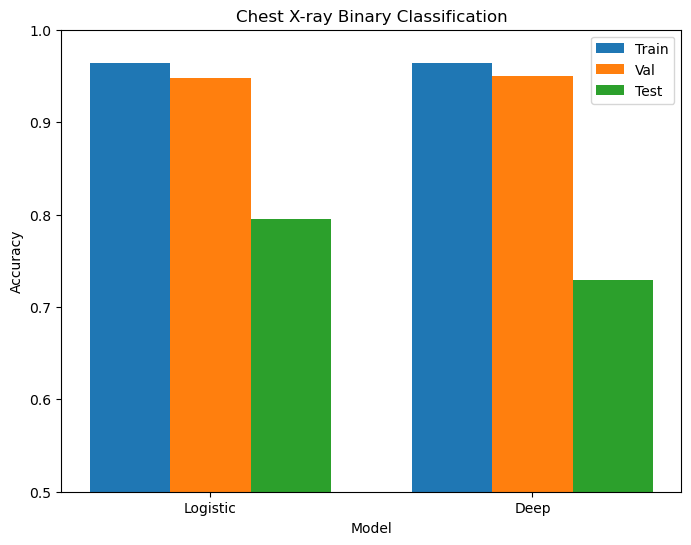

In [8]:
# train/val/test 정확도 비교를 위한 시각화 bar plot 도출 부분
train_acc = [train_accs_logreg[2], train_accs_deepnn[2]]
val_acc = [val_accs_logreg[2], val_accs_deepnn[2]]
test_acc = [test_accs_logreg[2], test_accs_deepnn[2]]
models_names = ['Logistic', 'Deep']

r = range(len(models_names))
bar_width = 0.25

plt.figure(figsize=(8, 6))
plt.bar(r, train_acc, width=bar_width, label='Train')
plt.bar([p + bar_width for p in r], val_acc, width=bar_width, label='Val')
plt.bar([p + 2*bar_width for p in r], test_acc, width=bar_width, label='Test')

plt.xlabel('Model')
plt.xticks([p + bar_width for p in r], models_names)
plt.ylabel('Accuracy')
plt.title('Chest X-ray Binary Classification')
plt.legend()
plt.ylim(0.5, 1.0)
plt.show()

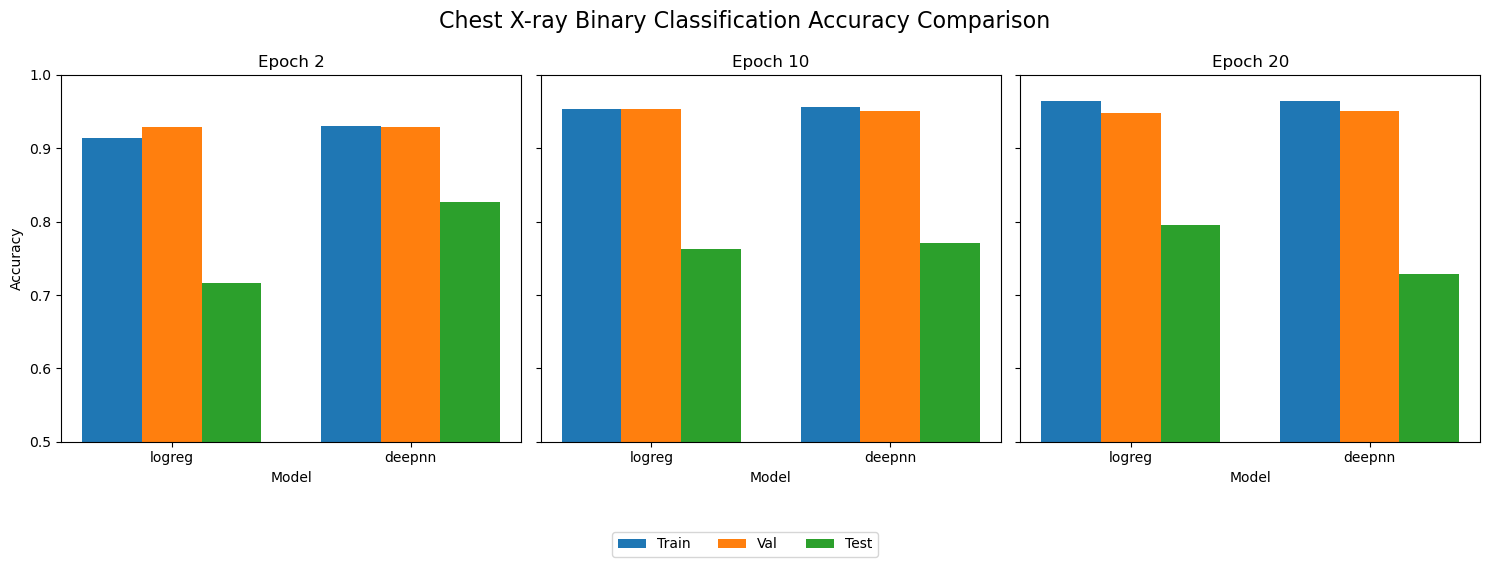

In [ ]:
# 모델 이름과 에포크
models_names = ['logreg', 'deepnn']
epoch_names = ['Epoch 2', 'Epoch 10', 'Epoch 20']

# Subplot 생성 (1행 3열)
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# 바 플롯 설정
bar_width = 0.25
r = range(len(models_names))

# 각 에포크에 대해 바 플롯 그리기
for i, ax in enumerate(axes):
    # 해당 에포크의 데이터
    train_acc = [train_accs_logreg[i], train_accs_deepnn[i]]
    val_acc = [val_accs_logreg[i], val_accs_deepnn[i]]
    test_acc = [test_accs_logreg[i], test_accs_deepnn[i]]

    ax.bar(r, train_acc, width=bar_width, label='Train' if i == 0 else "")
    ax.bar([p + bar_width for p in r], val_acc, width=bar_width, label='Val' if i == 0 else "")
    ax.bar([p + 2*bar_width for p in r], test_acc, width=bar_width, label='Test' if i == 0 else "")

    # X축, Y축 설정
    ax.set_xlabel('Model')
    ax.set_xticks([p + bar_width for p in r])
    ax.set_xticklabels(models_names)
    ax.set_ylim(0.5, 1.0)
    
    # 제목 설정
    ax.set_title(epoch_names[i])

# Y축 레이블 (공유)
axes[0].set_ylabel('Accuracy')

# 전체 제목
fig.suptitle('Chest X-ray Binary Classification Accuracy Comparison', fontsize=16)

# 범례 (첫 번째 subplot에만 표시, 전체에 적용)
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3)

# 레이아웃 조정
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # suptitle과 subplot 간 간격 조정
plt.show()

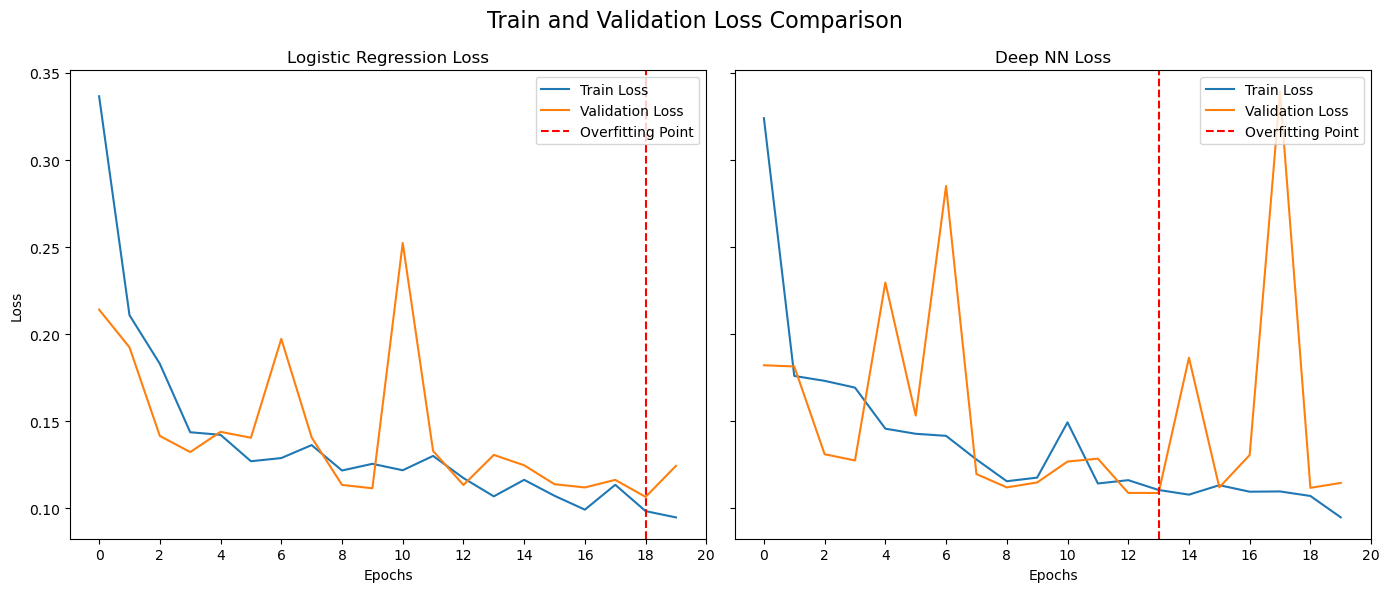

In [20]:
# Subplot 생성 (1행 2열)
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Logistic Regression Loss Plot
axes[0].plot(train_losses_logreg, label='Train Loss')
axes[0].plot(val_losses_logreg, label='Validation Loss')
axes[0].set_title('Logistic Regression Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_xticks(range(0, 21, 2))
axes[0].legend(loc='upper right')

# Overfitting 지점 표시 (Logistic Regression)
overfitting_epoch_logreg = val_losses_logreg.index(min(val_losses_logreg))
axes[0].axvline(overfitting_epoch_logreg, color='red', linestyle='--', label='Overfitting Point')
axes[0].legend(loc='upper right')

# Deep NN Loss Plot
axes[1].plot(train_losses_deepnn, label='Train Loss')
axes[1].plot(val_losses_deepnn, label='Validation Loss')
axes[1].set_title('Deep NN Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_xticks(range(0, 21, 2))
axes[1].legend(loc='upper right')

# Overfitting 지점 표시 (Deep NN)
overfitting_epoch_deepnn = val_losses_deepnn.index(min(val_losses_deepnn))
axes[1].axvline(overfitting_epoch_deepnn, color='red', linestyle='--', label='Overfitting Point')
axes[1].legend(loc='upper right')

# 전체 제목
fig.suptitle('Train and Validation Loss Comparison', fontsize=16)

# 레이아웃 조정
plt.tight_layout()
plt.show()